# comparePIPS_DSD.ipynb
## This notebook compares DSDs between collocated PIPS 

In [4]:
import numpy as N
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime,timedelta
import pytz as pytz
import sys
import os
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import modules.thermolib as thermo
import modules.DSDlib as dsd
import modules.disdrometer_module as dis
import pandas as pd
import glob
from scipy.stats import linregress
import statsmodels.api as sm
import xarray as xr
%load_ext autoreload
%matplotlib inline
%autoreload 2

### First, define some functions below: 

In [5]:
# Function definitions
def interpnan1D(a):
    """Replaces NaN's in a 1D array by interpolating from good values on either side"""
    ind = N.where(~N.isnan(a))[0] # indices of valid values
    return N.interp(range(len(a)),ind,a[ind]) # Use valid values to interpolate to invalid values
def interpcircnan1D(a):
    """Replaces NaN's in a 1D array by interpolating from good values on either side (circular version for wind directions)"""
    ind = N.where(~N.isnan(a))[0] # indices of valid values
    a[ind] = N.unwrap(a[ind])
    a = N.mod(N.interp(range(len(a)),ind,a[ind]),360.)
    return a # N.interp(range(len(a)),ind,a[ind])
def computeuv(spd,wdir):
    u = spd*N.cos(N.deg2rad(-wdir+270.))
    v = spd*N.sin(N.deg2rad(-wdir+270.))
    return u,v
def computedir(u,v):
    wdir = 270.-(180./N.pi)*N.arctan2(v,u)
    return N.mod(wdir,360.)
def anglediffdeg(a,b):
    c = a - b
    return (c+180)%360-180
def computebias(df):
    """Computes the mean across the columns of the given dataframe df.
       Then computes the difference of each column from the mean.
       Then computes the mean difference (bias) for each column.
       Returns a dataframe with the differences from the mean as well as a
       Series with the mean bias."""
    df_mean = df.mean(axis=1)
    df_diff = df.copy()
    # Not sure I need to loop through the columns...
    for col in list(df):
        df_diff[col]=df[col]-df_mean
    df_bias = df_diff.mean(axis=0)
    df_bias.name='Bias'
    return df_diff,df_bias
def computewinddirbias(u_df,v_df):
    """Like computebias, but for wind speed and direction. Returns bias for
       wind direction and the u and v wind components."""
    # Compute the wind direction from the u and v components
    winddir_df = computedir(u_df,v_df)
    # Next, compute the mean u and v components across the columns
    u_df_mean = u_df.mean(axis=1)
    v_df_mean = v_df.mean(axis=1)
    # Next, compute the mean wind directions from the means of the u and v components
    winddir_df_mean = computedir(u_df_mean,v_df_mean)
    # Now, compute the wind direction differences from the means (shortest angular difference)
    winddir_df_diff = winddir_df.copy()
    for col in list(winddir_df):
        winddir_df_diff[col]=anglediffdeg(winddir_df[col],winddir_df_mean)
    winddir_df_bias = winddir_df_diff.mean(axis=0)
    # Finally, compute the differences and bias for the u and v components separately
    u_df_diff,u_df_bias = computebias(u_df)
    v_df_diff,v_df_bias = computebias(v_df)
    winddir_df_bias.name='Bias'
    u_df_bias.name='Bias'
    v_df_bias.name='Bias'
    return winddir_df_diff,winddir_df_bias,u_df_diff,u_df_bias,v_df_diff,v_df_bias

# The following two functions are from http://stackoverflow.com/questions/19379295/linear-regression-with-pandas-dataframe?rq=1
def fit_line1(x, y):
    """Return slope, intercept of best fit line."""
    # Remove entries where either x or y is NaN.
    clean_data = pd.concat([x, y], 1).dropna(0) # row-wise
    (_, x), (_, y) = clean_data.iteritems()
    slope, intercept, r, p, stderr = linregress(x, y)
    return slope, intercept # could also return stderr

def fit_line2(x, y):
    """Return slope, intercept of best fit line."""
    X = sm.add_constant(x)
    model = sm.OLS(y, X, missing='drop') # ignores entires where x or y is NaN
    fit = model.fit()
    return fit.params[1], fit.params[0] # could also return stderr in each via fit.bse

In [6]:
dis_dir = '/Users/dawson29/Dropbox/PIPS_data/processed/061416_061616/'
dis_files = glob.glob(dis_dir+'*.txt')
print dis_files

['/Users/dawson29/Dropbox/PIPS_data/processed/061416_061616/PIPS_1A_061416_061616_D1.txt', '/Users/dawson29/Dropbox/PIPS_data/processed/061416_061616/PIPS_1B_061416_061616_D1.txt', '/Users/dawson29/Dropbox/PIPS_data/processed/061416_061616/PIPS_2A_061416_061616_D1.txt', '/Users/dawson29/Dropbox/PIPS_data/processed/061416_061616/PIPS_2B_061416_061616_D1.txt']


### Read in the PIPS data 

In [14]:
derived_DSD_ds_dict = {}
PIPSnames=[]

for dis_file in dis_files:
    conv_data_df,concentrations_df,onedrop_concentrations_df,derived_DSD_df,DSD_interval,DSD_intervalstr = dis.readPIPSdf(dis_file,rainonlyqc=False,DSD_interval=10.0)

    filename = os.path.split(dis_file)[1]
    PIPSname = filename[:7]
    PIPSnames.append(PIPSname)

    # Create a Dataset from the DataFrame
    derived_DSD_ds = xr.Dataset(derived_DSD_df)
    derived_DSD_ds_dict[PIPSname] = derived_DSD_ds

# Join the derived DSD Datasets into a single Dataset, using only the common times for each
# First, align the Datasets along the time dimension, excluding those times that aren't common to all
derived_DSD_ds_aligned = xr.align(*derived_DSD_ds_dict.values(),join='inner')
print derived_DSD_ds_aligned
#derived_DSD_ds_combined = xr.concat(*derived_DSD_ds_aligned,pd.Index(PIPSnames,name='PIPS_name'))

140616 133028
2016-06-14 13:30:28
2016 6 14 13 30 28
2016-06-14 13:30:28 2016-06-14 13:30:28
GPS Offset 0:00:00
Requested DSD interval: 10.0. Actual DSD interval: 10.0
140616 133628
2016-06-14 13:36:28
2016 6 14 13 36 28
2016-06-14 13:36:28 2016-06-14 13:36:28
GPS Offset 0:00:00
Requested DSD interval: 10.0. Actual DSD interval: 10.0
140616 134357
2016-06-14 13:43:57
2016 6 14 13 43 57
2016-06-14 13:43:57 2016-06-14 13:43:57
GPS Offset 0:00:00
Requested DSD interval: 10.0. Actual DSD interval: 10.0
140616 134834
2016-06-14 13:48:34
2016 6 14 13 48 34
2016-06-14 13:48:34 2016-06-14 13:48:34
GPS Offset 0:00:00
Requested DSD interval: 10.0. Actual DSD interval: 10.0
(<xarray.Dataset>
Dimensions:                  (Time: 16038)
Coordinates:
  * Time                     (Time) datetime64[ns] 2016-06-14T13:48:30 ...
Data variables:
    Bad wind flagged times   (Time) bool False False False False False False ...
    Derived particle counts  (Time) int64 2 3 0 2 4 2 2 2 2 3 0 4 0 1 2 5 6 ...
  

In [46]:
derived_DSD_ds_combined = xr.concat(derived_DSD_ds_aligned,pd.Index([1,2,3,4],name='PIPS_name'))
print derived_DSD_ds_combined

<xarray.Dataset>
Dimensions:                  (PIPS_name: 4, Time: 16038)
Coordinates:
  * Time                     (Time) datetime64[ns] 2016-06-14T13:48:30 ...
  * PIPS_name                (PIPS_name) int64 1 2 3 4
Data variables:
    Bad wind flagged times   (PIPS_name, Time) bool False False False False ...
    Derived particle counts  (PIPS_name, Time) int64 2 3 0 2 4 2 2 2 2 3 0 4 ...
    Particle counts          (PIPS_name, Time) int64 2 3 0 2 4 2 2 2 2 3 0 4 ...
    Precipitation intensity  (PIPS_name, Time) float64 0.0 0.0 0.0 0.0 0.0 ...
    Precipitation totals     (PIPS_name, Time) float64 0.0 0.0 0.0 0.0 0.0 ...
    Radar reflectivity       (PIPS_name, Time) float64 -9.999 -9.999 -9.999 ...


### Plot the derived DSD data

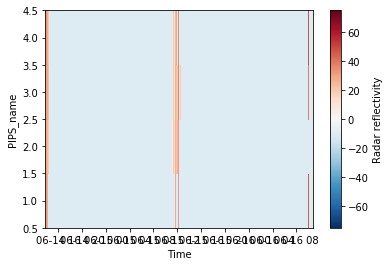

In [48]:
temp = derived_DSD_ds_combined['Radar reflectivity']
temp.plot()

### Plot the resampled (time-averaged) data

In [ ]:
windspdsavg_df.plot(figsize=(10,6),title=r'{0}-s mean scalar wind speed (m s$^{{-1}}$)'.format(avginterval))
windspdsavgvec_df.plot(figsize=(10,6),title=r'{0}-s mean vector wind speed (m s$^{{-1}}$)'.format(avginterval))
winddirsavgvec_df.plot(figsize=(10,6),title=r'{0}-s mean vector wind direction ($^{{\circ}}$)'.format(avginterval))
winddirsunitavgvec_df.plot(figsize=(10,6),title=r'{0}-s mean unit vector wind direction ($^{{\circ}}$)'.format(avginterval))
uavg_df.plot(figsize=(10,6),title=r'{0}-s mean u wind component (m s$^{{-1}}$)'.format(avginterval))
vavg_df.plot(figsize=(10,6),title=r'{0}-s mean v wind component (m s$^{{-1}}$)'.format(avginterval))
fasttempsavg_df.plot(figsize=(10,6),title=r'{0}-s mean fast temperature (K)'.format(avginterval))
slowtempsavg_df.plot(figsize=(10,6),title=r'{0}-s mean slow temperature (K)'.format(avginterval))
dewpointsavg_df.plot(figsize=(10,6),title=r'{0}-s mean dewpoint temperature (K)'.format(avginterval))
RHsavg_df.plot(figsize=(10,6),title=r'{0}-s mean relative humidity (%)'.format(avginterval))
pressuresavg_df.plot(figsize=(10,6),title=r'{0}-s mean pressure (hPa)'.format(avginterval))

### Compute the differences from the mean for each PIPS, and the mean difference (bias) from the mean

In [ ]:
from pandas.tools.plotting import table
winddir_df_diff,winddir_df_bias,u_df_diff,u_df_bias,v_df_diff,v_df_bias = computewinddirbias(u_df,v_df)

# Scalar wind speed
windspds_diff,windspds_bias = computebias(windspds_df)
fig,ax=plt.subplots(1,1)
table(ax, N.round(windspds_bias, 4),loc='upper right',colWidths=[0.1])
windspds_diff.plot(ax=ax,figsize=(10,6),title=r'Scalar wind speed difference from mean (m s$^{-1}$)')
ax.legend(loc='upper left')

# Wind direction
fig,ax=plt.subplots(1,1)
table(ax, N.round(winddir_df_bias, 4),loc='upper right',colWidths=[0.1])
winddir_df_diff.plot(ax=ax,figsize=(10,6),title=r'Wind direction difference from mean ($^{\circ}$)')
ax.legend(loc='upper left')

# U-wind component
fig,ax=plt.subplots(1,1)
table(ax, N.round(u_df_bias, 4),loc='upper right',colWidths=[0.1])
u_df_diff.plot(ax=ax,figsize=(10,6),title=r'U wind component difference from mean (m s$^{-1}$)')
ax.legend(loc='upper left')

# V-wind component
fig,ax=plt.subplots(1,1)
table(ax, N.round(v_df_bias, 4),loc='upper right',colWidths=[0.1])
v_df_diff.plot(ax=ax,figsize=(10,6),title=r'V wind component difference from mean (m s$^{-1}$)')
ax.legend(loc='upper left')

# Fast temperature
fasttemps_diff,fasttemps_bias = computebias(fasttemps_df)
fig,ax=plt.subplots(1,1)
table(ax, N.round(fasttemps_bias, 4),loc='upper right',colWidths=[0.1])
fasttemps_diff.plot(ax=ax,figsize=(10,6),title=r'Fast temperature difference from mean (K)')
ax.legend(loc='upper left')

# Slow temperature
slowtemps_diff,slowtemps_bias = computebias(slowtemps_df)
fig,ax=plt.subplots(1,1)
table(ax, N.round(slowtemps_bias, 4),loc='upper right',colWidths=[0.1])
slowtemps_diff.plot(ax=ax,figsize=(10,6),title=r'Slow temperature difference from mean (K)')
ax.legend(loc='upper left')

# Dewpoint temperature
dewpoints_diff,dewpoints_bias = computebias(dewpoints_df)
fig,ax=plt.subplots(1,1)
table(ax, N.round(dewpoints_bias, 4),loc='upper right',colWidths=[0.1])
dewpoints_diff.plot(ax=ax,figsize=(10,6),title=r'Dewpoint temperature difference from mean (K)')
ax.legend(loc='upper left')

# Relative humidity
RHs_diff,RHs_bias = computebias(RHs_df)
fig,ax=plt.subplots(1,1)
table(ax, N.round(RHs_bias, 4),loc='upper right',colWidths=[0.1])
RHs_diff.plot(ax=ax,figsize=(10,6),title=r'Relative humidity difference from mean (%)')
ax.legend(loc='upper left')

# Pressure
pressures_diff,pressures_bias = computebias(pressures_df)
fig,ax=plt.subplots(1,1)
table(ax, N.round(pressures_bias, 4),loc='upper right',colWidths=[0.1])
pressures_diff.plot(ax=ax,figsize=(10,6),title=r'Pressure difference from mean (hPa)')
ax.legend(loc='upper left')


### Make some scatter plots and linear regressions

In [ ]:
fig,ax = plt.subplots(1,1)
windspds_df.plot(ax=ax,x='PIPS_1A',y='PIPS_1B',kind='scatter')
x = windspds_df['PIPS_1A']
y = windspds_df['PIPS_1B']
m,b = fit_line2(x,y)
npoints = 100 # could be just 2 if you are only drawing a straight line...
points = N.linspace(x.min(), x.max(), npoints)
plt.plot(points, m*points + b,c='k')


### Make a Bland–Altman plot

In [ ]:
# PIPS 2A compared to mean for a variable
fig,ax = plt.subplots(1,1)
windspds_df_mean = windspds_df.mean(axis=1)
x = (windspds_df['PIPS_1B']+windspds_df_mean)/2.
y = (windspds_df['PIPS_1B']-windspds_df_mean)
ax.scatter(x,y)
ax.axhline(y=0,c='k',ls='--')

In [ ]:
# Need to update this section!
# Compute bias of the time-resampled PIPS observations as a function of time
fasttempsavg_mean_df = fasttempsavg_df.mean(axis=1)
fasttempsavg_bias_df = fasttempsavg_df.copy()
fasttempsavg_bias_df['PIPS_1A']=fasttempsavg_df['PIPS_1A']-fasttempsavg_mean_df
fasttempsavg_bias_df['PIPS_1B']=fasttempsavg_df['PIPS_1B']-fasttempsavg_mean_df
fasttempsavg_bias_df['PIPS_2A']=fasttempsavg_df['PIPS_2A']-fasttempsavg_mean_df
fasttempsavg_bias_df['PIPS_2B']=fasttempsavg_df['PIPS_2B']-fasttempsavg_mean_df
fasttempsavg_bias = fasttempsavg_bias_df.mean(axis=0)
print "Resampled fast temps bias"
print fasttempsavg_bias

RHsavg_mean_df = RHsavg_df.mean(axis=1)
RHsavg_bias_df = RHsavg_df.copy()
RHsavg_bias_df['PIPS_1A']=RHsavg_df['PIPS_1A']-RHsavg_mean_df
RHsavg_bias_df['PIPS_1B']=RHsavg_df['PIPS_1B']-RHsavg_mean_df
RHsavg_bias_df['PIPS_2A']=RHsavg_df['PIPS_2A']-RHsavg_mean_df
RHsavg_bias_df['PIPS_2B']=RHsavg_df['PIPS_2B']-RHsavg_mean_df
RHsavg_bias = RHsavg_bias_df.mean(axis=0)
print "Resampled RH bias"
print RHsavg_bias

pressuresavg_mean_df = pressuresavg_df.mean(axis=1)
pressuresavg_bias_df = pressuresavg_df.copy()
pressuresavg_bias_df['PIPS_1A']=pressuresavg_df['PIPS_1A']-pressuresavg_mean_df
pressuresavg_bias_df['PIPS_1B']=pressuresavg_df['PIPS_1B']-pressuresavg_mean_df
pressuresavg_bias_df['PIPS_2A']=pressuresavg_df['PIPS_2A']-pressuresavg_mean_df
pressuresavg_bias_df['PIPS_2B']=pressuresavg_df['PIPS_2B']-pressuresavg_mean_df
pressuresavg_bias = pressuresavg_bias_df.mean(axis=0)
print "Resampled pressure bias"
print pressuresavg_bias

uavg_mean_df = uavg_df.mean(axis=1) # *should* be the same as u_df.mean(axis=1)
vavg_mean_df = vavg_df.mean(axis=1)
uavg_bias_df = uavg_df.copy()
uavg_bias_df['PIPS_1A']=uavg_df['PIPS_1A']-uavg_mean_df
uavg_bias_df['PIPS_1B']=uavg_df['PIPS_1B']-uavg_mean_df
uavg_bias_df['PIPS_2A']=uavg_df['PIPS_2A']-uavg_mean_df
uavg_bias_df['PIPS_2B']=uavg_df['PIPS_2B']-uavg_mean_df
uavg_bias = uavg_bias_df.mean(axis=0)
print "Resampled u-wind bias"
print uavg_bias

vavg_bias_df = vavg_df.copy()
vavg_bias_df['PIPS_1A']=vavg_df['PIPS_1A']-vavg_mean_df
vavg_bias_df['PIPS_1B']=vavg_df['PIPS_1B']-vavg_mean_df
vavg_bias_df['PIPS_2A']=vavg_df['PIPS_2A']-vavg_mean_df
vavg_bias_df['PIPS_2B']=vavg_df['PIPS_2B']-vavg_mean_df
vavg_bias = vavg_bias_df.mean(axis=0)
print "Resampled v-wind bias"
print vavg_bias

winddiravgvec_mean_df = computedir(uavg_mean_df,vavg_mean_df)
winddiravgvec_bias_df = winddirsavgvec_df.copy()
# winddiravgvec_bias_df['PIPS_1A']=winddirsavgvec_df['PIPS_1A']-winddiravgvec_mean_df
# winddiravgvec_bias_df['PIPS_1B']=winddirsavgvec_df['PIPS_1B']-winddiravgvec_mean_df
# winddiravgvec_bias_df['PIPS_2A']=winddirsavgvec_df['PIPS_2A']-winddiravgvec_mean_df
# winddiravgvec_bias_df['PIPS_2B']=winddirsavgvec_df['PIPS_2B']-winddiravgvec_mean_df
winddiravgvec_bias_df['PIPS_1A']=anglediffdeg(winddirsavgvec_df['PIPS_1A'],winddiravgvec_mean_df)
winddiravgvec_bias_df['PIPS_1B']=anglediffdeg(winddirsavgvec_df['PIPS_1B'],winddiravgvec_mean_df)
winddiravgvec_bias_df['PIPS_2A']=anglediffdeg(winddirsavgvec_df['PIPS_2A'],winddiravgvec_mean_df)
winddiravgvec_bias_df['PIPS_2B']=anglediffdeg(winddirsavgvec_df['PIPS_2B'],winddiravgvec_mean_df)
winddiravgvec_bias = winddiravgvec_bias_df.mean(axis=0)
print "Resampled wind direction bias"
print winddiravgvec_bias

unit_uavg_mean_df = unit_uavg_df.mean(axis=1)
unit_vavg_mean_df = unit_vavg_df.mean(axis=1)
winddirunitavgvec_mean_df = computedir(unit_uavg_mean_df,unit_vavg_mean_df)
winddirunitavgvec_bias_df = winddirsunitavgvec_df.copy()
# winddiravgvec_bias_df['PIPS_1A']=winddirsavgvec_df['PIPS_1A']-winddiravgvec_mean_df
# winddiravgvec_bias_df['PIPS_1B']=winddirsavgvec_df['PIPS_1B']-winddiravgvec_mean_df
# winddiravgvec_bias_df['PIPS_2A']=winddirsavgvec_df['PIPS_2A']-winddiravgvec_mean_df
# winddiravgvec_bias_df['PIPS_2B']=winddirsavgvec_df['PIPS_2B']-winddiravgvec_mean_df
winddirunitavgvec_bias_df['PIPS_1A']=anglediffdeg(winddirsunitavgvec_df['PIPS_1A'],winddirunitavgvec_mean_df)
winddirunitavgvec_bias_df['PIPS_1B']=anglediffdeg(winddirsunitavgvec_df['PIPS_1B'],winddirunitavgvec_mean_df)
winddirunitavgvec_bias_df['PIPS_2A']=anglediffdeg(winddirsunitavgvec_df['PIPS_2A'],winddirunitavgvec_mean_df)
winddirunitavgvec_bias_df['PIPS_2B']=anglediffdeg(winddirsunitavgvec_df['PIPS_2B'],winddirunitavgvec_mean_df)
winddirunitavgvec_bias = winddirunitavgvec_bias_df.mean(axis=0)
print "Resampled unit wind direction bias"
print winddirunitavgvec_bias

windspdsavgvec_mean_df = windspdsavgvec_df.mean(axis=1)
windspdsavgvec_bias_df = windspdsavgvec_df.copy()
windspdsavgvec_bias_df['PIPS_1A']=windspdsavgvec_df['PIPS_1A']-windspdsavgvec_mean_df
windspdsavgvec_bias_df['PIPS_1B']=windspdsavgvec_df['PIPS_1B']-windspdsavgvec_mean_df
windspdsavgvec_bias_df['PIPS_2A']=windspdsavgvec_df['PIPS_2A']-windspdsavgvec_mean_df
windspdsavgvec_bias_df['PIPS_2B']=windspdsavgvec_df['PIPS_2B']-windspdsavgvec_mean_df
windspdsavgvec_bias = windspdsavgvec_bias_df.mean(axis=0)
print "Resampled windspeed bias"
print windspdsavgvec_bias

In [ ]:
windspds_bias.columns
windspds_bias.rename(columns={'None': 'Bias'}, inplace=True)
windspds_df

In [ ]:
fasttempsavg_bias_df.plot(figsize=(10,6))
RHsavg_bias_df.plot(figsize=(10,6))
pressuresavg_bias_df.plot(figsize=(10,6))
uavg_bias_df.plot(figsize=(10,6))
vavg_bias_df.plot(figsize=(10,6))
winddiravgvec_bias_df.plot(figsize=(10,6))
winddirunitavgvec_bias_df.plot(figsize=(10,6))
windspdsavgvec_bias_df.plot(figsize=(10,6))

In [ ]:
list(u_df)
temp = computedir(u_df,v_df)
list(temp)
for col in list(temp):
    print col
    print temp[col]

In [ ]:
# Scratch code below, don't execute!
    
    # Convert to numpy arrays
    windspds = N.array(windspds)
    winddirrels = N.array(winddirrels)
    winddirabss = N.array(winddirabss)
    fasttemps = N.array(fasttemps)
    slowtemps = N.array(slowtemps)
    dewpoints = N.array(dewpoints)
    RHs_derived = N.array(RHs_derived)
    RHs = N.array(RHs)
    pressures = N.array(pressures)
    pcounts = N.array(pcounts)
    pcounts2 = N.array(pcounts2)
    intensities = N.array(intensities)

    Nc_bin = concentrations.T
    dropperbin = onedrop_concentrations.T

    logNc_bin = N.ma.log10(Nc_bin)
    logNc_bin = N.ma.masked_where(Nc_bin < dropperbin, logNc_bin)

    # Compute potential temperature, water vapor mixing ratio, and density
    pt = thermo.caltheta(pressures*100.,slowtemps+273.15)
    qv = thermo.calqv(RHs/100.,pressures*100.,slowtemps+273.15)
    rho=thermo.calrho(pressures*100.,pt,qv)